In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
%matplotlib inline
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (recall_score, roc_curve, confusion_matrix, accuracy_score,
                             classification_report, precision_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [67]:
df = pd.read_parquet('data/compras.parquet', engine='pyarrow')
df.head()

,A3D,BAR-GOURMET,COMUNICACIONES,CORPORATIVA,CUIDADO_PERSONAL,ELECTRO,ESCRITURA Y ACCESORIOS,EVENTOS,GIFTCARD,HOGAR,IMAGEN,LIBRERIA,LINEA_BLANCA,MUNDO APPLE,MUNDO_BEBE,MUNDO_VIAJES,PERFUMES,PRODUCTOS DESCONTINUADOS,Pyme,RELOJES_ JOYAS_REGALOS,SOHO,SONIDO,TIEMPO_LIBRE,VENTA_EMPLEADOS,VIDEO_Y_CONSOLAS,SUCURSAL,FECHA,ANO,MES,DIA,HORA,CANTIDAD_TOTAL,REGION_CLIENTE,REGION_DESPACHO,CANTIDADCANJES,$_RECAUDACIONDESCUENTO,RECAUDACIONDP,$_RECAUDACIONDP,$_RECAUDACIONTC,$_RECAUDACIONDEBITO,NRO_CUOTAS,DOLARES_PREMIO,$_TC,$_DP,$_BRUTO,$_NETO,$_COSTO,$_PRECIO_REF,PESO_KG_TOTAL,$_FLETE_TOTAL,SALDO_DP,NUMERO_CUOTAS,TIPO_DTE,TIPO_CLIENTE,TIPO_CAMBIO,TIENDA,FreqTransaccionAnualxVenta,FrecuenciaTransaccionesHistorico,NUEVA_COMPRA_EM_4_MESES,%DP_USADO,%NETO_VS_COSTO,DIF_NETO_COSTO,%DP_USADO_VS_SALDODP,%SALDODP_PESOS_VS_BRUTO,%DP_VS_COSTO
59020,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VENTA WEB,2015-01-01 01:00:00,2015,1,1,1,1,Región Metropolitana,Región Metropolitana,0,0,443.33,269988,3950,0,0,443.33,2,269988,269990,226882,187827,0,12.0,3950,1011.64,0,Boleta,Clasico,609.0,DF,3,8,0,1.042465,1.278907,49479,0.438229,2.281895,1.437429
338784,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,VENTA WEB,2015-01-01 03:00:00,2015,1,1,3,1,Región Metropolitana,Región Metropolitana,1,0,49.10,29902,2900,0,0,49.10,0,29902,29900,25126,19995,0,2.0,2900,202.50,0,Boleta,Clasico,609.0,DF,2,8,0,0.314791,0.303887,-57556,0.242469,4.124498,1.495474
361047,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VENTA WEB,2015-01-01 04:00:00,2015,1,1,4,2,VIII Región,VIII Región,1,0,59.66,36333,15148,0,0,59.66,9647,36333,22990,19319,11433,0,2.0,5500,139.50,0,Boleta,Clasico,609.0,DF,9,22,0,0.660720,0.514172,-18254,0.427670,3.695324,3.177906
157061,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VENTA WEB,2015-01-01 07:00:00,2015,1,1,7,2,Región Metropolitana,Región Metropolitana,2,0,26.34,16041,20091,0,0,26.34,13541,16041,29580,24856,16803,0,20.0,6550,76.35,0,Boleta,Clasico,609.0,DF,2,16,0,0.180236,0.474777,-27497,0.344990,1.571912,0.954651
450013,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,VENTA WEB,2015-01-01 09:00:00,2015,1,1,9,1,Región Metropolitana,Región Metropolitana,1,0,623.84,379919,30671,0,3,623.84,20071,379919,399990,336126,285707,0,70.0,10600,623.85,3,Boleta,Clasico,609.0,DF,4,17,0,3.799190,4.309308,258126,0.999984,0.949835,1.329750


In [68]:
df['NUEVA_COMPRA_EM_4_MESES'].value_counts()

0    302963
1    240127
Name: NUEVA_COMPRA_EM_4_MESES, dtype: int64

In [3]:
promedio = df['$_NETO'] - df['$_COSTO']
promedio = promedio.mean()
promedio

22577.470691782208

In [6]:
df.drop(columns=['SUCURSAL','REGION_CLIENTE', 'TIPO_DTE', 'TIPO_CLIENTE', '$_NETO', '$_COSTO'], inplace=True)

In [7]:
categorical = list(df.select_dtypes(include='object').columns)
categorical

['REGION_DESPACHO', 'TIENDA']

In [8]:
y = df['NUEVA_COMPRA_EM_4_MESES']
df.drop(columns=['NUEVA_COMPRA_EM_4_MESES'], inplace=True)

In [9]:
enc = OneHotEncoder(handle_unknown='ignore')
data = enc.fit_transform(df[categorical]).toarray()

In [10]:
data.shape

(543090, 19)

In [11]:
df_features = pd.DataFrame(data)

In [12]:
df.drop(columns=categorical, inplace=True)
df.drop(columns=['FECHA'], inplace=True)

In [13]:
df_merged = pd.concat([df, df_features], axis=1)
df_merged.dropna(inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.head()

,A3D,BAR-GOURMET,COMUNICACIONES,CORPORATIVA,CUIDADO_PERSONAL,ELECTRO,ESCRITURA Y ACCESORIOS,EVENTOS,GIFTCARD,HOGAR,IMAGEN,LIBRERIA,LINEA_BLANCA,MUNDO APPLE,MUNDO_BEBE,MUNDO_VIAJES,PERFUMES,PRODUCTOS DESCONTINUADOS,Pyme,RELOJES_ JOYAS_REGALOS,SOHO,SONIDO,TIEMPO_LIBRE,VENTA_EMPLEADOS,VIDEO_Y_CONSOLAS,ANO,MES,DIA,HORA,CANTIDAD_TOTAL,CANTIDADCANJES,$_RECAUDACIONDESCUENTO,RECAUDACIONDP,$_RECAUDACIONDP,$_RECAUDACIONTC,$_RECAUDACIONDEBITO,NRO_CUOTAS,DOLARES_PREMIO,$_TC,$_DP,$_BRUTO,$_PRECIO_REF,PESO_KG_TOTAL,$_FLETE_TOTAL,SALDO_DP,NUMERO_CUOTAS,TIPO_CAMBIO,FreqTransaccionAnualxVenta,FrecuenciaTransaccionesHistorico,%DP_USADO,%NETO_VS_COSTO,DIF_NETO_COSTO,%DP_USADO_VS_SALDODP,%SALDODP_PESOS_VS_BRUTO,%DP_VS_COSTO,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2015,4,30,13,2,2,0,68.92,42593,102588,0,0,68.92,99388,42593,141980,0,3.9,3200,181.00,0,618.0,2,12,0.157758,0.635207,-68518,0.380773,0.787843,0.445692,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015,10,27,20,1,1,0,31.25,21594,18346,0,0,31.25,14396,21594,35990,0,10.0,3950,143.58,0,691.0,2,12,0.722207,1.512528,10248,0.217649,2.756704,1.070972,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,2016,1,12,13,4,4,0,60.97,43959,13601,0,0,60.97,11001,43959,54960,0,0.8,2600,112.33,0,721.0,3,12,1.912092,4.039447,34750,0.542776,1.473616,1.359697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,7,18,18,1,0,0,0.00,0,193940,0,0,0.00,189990,0,189990,0,10.0,3950,98.36,0,650.0,3,12,0.000000,9.501577,142852,0.000000,0.336512,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2016,11,15,7,4,3,0,98.35,64518,66163,0,0,98.35,62263,64517,96880,34900,7.9,3900,98.36,0,656.0,3,12,0.161297,0.284946,-204296,0.999898,0.666021,1.027292,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
df_merged.shape

(543090, 74)

In [15]:
x = df_merged
sc = MinMaxScaler()
x = sc.fit_transform(x)

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

Accuracy, Recall, Precission, Fbeta

In [33]:
def trainning(model, model_name):
    results = []
    iteration = 1

    # Cross-validation para TimeSeries
    for train_index, test_index in tscv.split(x):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = model.fit(x_train, y_train)
        model_name = model_name
        
        # Generar tabla umbral
        for umbral in range(1, 10):
            umbral = umbral / 10
            y_pred = (model.predict_proba(x_test)[:,1] >= umbral).astype(int)
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            f1_score = 2 * precision * recall / (precision + recall)
            cm = confusion_matrix(y_test, y_pred)
            (tn, fp, fn, tp) = cm.flatten() * (5/3)
            
            results.append([model_name, umbral, accuracy, recall, precision, f1_score, tn, tp, fn, fp])
        iteration += 1

    return pd.DataFrame(results, columns=["model_name", "umbral", "accuracy", "recall", "precision", "f1_score", "tn", "tp", "fn", "fp"])

In [34]:
models = []
models.append(("LogisticRegression", LogisticRegression(max_iter=1000, solver='liblinear')))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier(max_depth=2, random_state=0)))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))

In [35]:
result = pd.DataFrame()
for i in range(0,len(models)):
    result = result.append(trainning(models[i][1], models[i][0]))

TRAIN: [    0     1     2 ... 90512 90513 90514] TEST: [ 90515  90516  90517 ... 181027 181028 181029]
TRAIN: [     0      1      2 ... 181027 181028 181029] TEST: [181030 181031 181032 ... 271542 271543 271544]
TRAIN: [     0      1      2 ... 271542 271543 271544] TEST: [271545 271546 271547 ... 362057 362058 362059]
TRAIN: [     0      1      2 ... 362057 362058 362059] TEST: [362060 362061 362062 ... 452572 452573 452574]
TRAIN: [     0      1      2 ... 452572 452573 452574] TEST: [452575 452576 452577 ... 543087 543088 543089]
TRAIN: [    0     1     2 ... 90512 90513 90514] TEST: [ 90515  90516  90517 ... 181027 181028 181029]
TRAIN: [     0      1      2 ... 181027 181028 181029] TEST: [181030 181031 181032 ... 271542 271543 271544]
TRAIN: [     0      1      2 ... 271542 271543 271544] TEST: [271545 271546 271547 ... 362057 362058 362059]
TRAIN: [     0      1      2 ... 362057 362058 362059] TEST: [362060 362061 362062 ... 452572 452573 452574]
TRAIN: [     0      1      2 ..

In [36]:
result['TPR'] = result['tp']/(result['tp'] + result['fn'])

In [37]:
result['FPR'] = (result['fp']/(result['fp'] + result['tn']))

In [38]:
result['Sensitivity'] = result['tp']/(result['tp'] + result['fn'])

In [39]:
result['Specificity'] = 1 - result['FPR']

In [40]:
result['g-mean'] = sqrt(result['Sensitivity'] * result['Specificity'])

In [41]:
result["Cost"] = promedio * result["fn"] 

In [42]:
result["Cost_mail"] = 1600 / 100000 * result["tp"]

In [60]:
result.drop(columns=["g-mean"], inplace=True)

In [61]:
result_df = result.groupby(["model_name","umbral"]).mean()
result_df.sort_values(by=['f1_score'], ascending=False)

accuracy    recall  precision  f1_score  \
model_name             umbral                                            
xgb.XGBClassifier      0.4     0.765347  0.846557   0.682081  0.755456   
                       0.3     0.730416  0.932952   0.623895  0.747579   
LogisticRegression     0.3     0.742021  0.866768   0.648841  0.742033   
xgb.XGBClassifier      0.5     0.774181  0.745956   0.731949  0.738761   
                       0.2     0.689866  0.986130   0.581510  0.731216   
LogisticRegression     0.4     0.763100  0.736325   0.717316  0.726227   
xgb.XGBClassifier      0.1     0.672251  0.996732   0.566946  0.722305   
RandomForestClassifier 0.4     0.666170  0.910074   0.573723  0.702227   
xgb.XGBClassifier      0.6     0.766598  0.626497   0.785261  0.696511   
LogisticRegression     0.2     0.628572  0.979215   0.536603  0.693049   
                       0.5     0.754394  0.602813   0.772896  0.676107   
RandomForestClassifier 0.5     0.745317  0.644877   0.729422  0.675873   
DecisionTreeClassifier 0.2     0.705291  0.658972   0.655675  0.657272   
                       0.1     0.705291  0.658972   0.655675  0.657272   
                       0.3     0.705291  0.658972   0.655675  0.657272   
                       0.4     0.705291  0.658972   0.655675  0.657272   
                       0.5     0.705291  0.658972   0.655675  0.657272   
                       0.6     0.705291  0.658972   0.655675  0.657272   
                       0.7     0.705291  0.658972   0.655675  0.657272   
                       0.8     0.705291  0.658972   0.655675  0.657272   
                       0.9     0.705291  0.658972   0.655675  0.657272   
xgb.XGBClassifier      0.7     0.741658  0.494046   0.836411  0.620323   
LogisticRegression     0.6     0.734495  0.492903   0.813429  0.612262   
                       0.1     0.433482  0.999961   0.432393  0.602155   
GaussianNB             0.7     0.490942  0.891571   0.462986  0.601781   
                       0.8     0.503103  0.868146   0.474783  0.601674   
RandomForestClassifier 0.2     0.431621  1.000000   0.431621  0.601395   
                       0.3     0.431621  1.000000   0.431621  0.601395   
                       0.1     0.431621  1.000000   0.431621  0.601395   
GaussianNB             0.6     0.480608  0.906628   0.454888  0.600461   
                       0.3     0.466122  0.931673   0.446193  0.599984   
                       0.4     0.470307  0.923869   0.448448  0.599947   
                       0.5     0.474536  0.916065   0.450911  0.599937   
                       0.2     0.461252  0.939737   0.443827  0.599812   
                       0.1     0.455776  0.949094   0.441243  0.599685   
                       0.9     0.519890  0.828080   0.494123  0.598096   
LogisticRegression     0.7     0.709701  0.394546   0.846333  0.536735   
xgb.XGBClassifier      0.8     0.700518  0.346590   0.887675  0.497513   
LogisticRegression     0.8     0.680694  0.297826   0.877838  0.443512   
                       0.9     0.645603  0.195228   0.911523  0.320826   
xgb.XGBClassifier      0.9     0.642700  0.181177   0.943159  0.303451   
RandomForestClassifier 0.6     0.581678  0.032429   0.917067  0.061004   
                       0.7     0.568379  0.000000   0.000000       NaN   
                       0.8     0.568379  0.000000   0.000000       NaN   
                       0.9     0.568379  0.000000   0.000000       NaN   

                                         tn            tp            fn  \
model_name             umbral                                             
xgb.XGBClassifier      0.4     60190.333333  55268.666667   9845.000000   
                       0.3     49378.666667  60810.666667   4303.000000   
LogisticRegression     0.3     55255.666667  56684.333333   8429.333333   
xgb.XGBClassifier      0.5     68009.000000  48782.666667  16331.000000   
                       0.2     39846.333333  64225.666667    888.000000   
LogisticRegression     0.4 

In [44]:
result_df.reset_index(drop=False, inplace=True)

G-mean max

In [45]:
result_df['g-mean'].max()

0.7682236120359826

In [50]:
best_model = result_df[result_df['g-mean'] == 0.7682236120359826]
best_model

,model_name,umbral,accuracy,recall,precision,f1_score,tn,tp,fn,fp,TPR,FPR,Sensitivity,Specificity,g-mean,Cost,Cost_mail
39,xgb.XGBClassifier,0.4,0.765347,0.846557,0.682081,0.755456,60190.333333,55268.666667,9845.0,25554.333333,0.846557,0.301596,0.846557,0.698404,0.768224,2.222752e+08,884.298667


In [47]:
xgb_df = result_df[result_df['model_name'] == 'xgb.XGBClassifier']
xgb_df

,model_name,umbral,accuracy,recall,precision,f1_score,tn,tp,fn,fp,TPR,FPR,Sensitivity,Specificity,g-mean,Cost,Cost_mail
36,xgb.XGBClassifier,0.1,0.672251,0.996732,0.566946,0.722305,36510.000000,64904.666667,209.000000,49234.666667,0.996732,0.577855,0.996732,0.422145,0.647717,4.718691e+06,1038.474667
37,xgb.XGBClassifier,0.2,0.689866,0.986130,0.581510,0.731216,39846.333333,64225.666667,888.000000,45898.333333,0.986130,0.539087,0.986130,0.460913,0.673233,2.004879e+07,1027.610667
38,xgb.XGBClassifier,0.3,0.730416,0.932952,0.623895,0.747579,49378.666667,60810.666667,4303.000000,36366.000000,0.932952,0.427817,0.932952,0.572183,0.729923,9.715086e+07,972.970667
39,xgb.XGBClassifier,0.4,0.765347,0.846557,0.682081,0.755456,60190.333333,55268.666667,9845.000000,25554.333333,0.846557,0.301596,0.846557,0.698404,0.768224,2.222752e+08,884.298667
40,xgb.XGBClassifier,0.5,0.774181,0.745956,0.731949,0.738761,68009.000000,48782.666667,16331.000000,17735.666667,0.745956,0.209866,0.745956,0.790134,0.767031,3.687127e+08,780.522667
41,xgb.XGBClassifier,0.6,0.766598,0.626497,0.785261,0.696511,74590.000000,41057.666667,24056.000000,11154.666667,0.626497,0.132345,0.626497,0.867655,0.736529,5.431236e+08,656.922667
42,xgb.XGBClassifier,0.7,0.741658,0.494046,0.836411,0.620323,79435.333333,32450.000000,32663.666667,6309.333333,0.494046,0.075033,0.494046,0.924967,0.675141,7.374630e+08,519.200000
43,xgb.XGBClassifier,0.8,0.700518,0.346590,0.887675,0.497513,82869.333333,22809.666667,42304.000000,2875.333333,0.346590,0.034279,0.346590,0.965721,0.577630,9.551173e+08,364.954667
44,xgb.XGBClassifier,0.9,0.642700,0.181177,0.943159,0.303451,85027.333333,11929.333333,53184.333333,717.333333,0.181177,0.008560,0.181177,0.991440,0.423122,1.200768e+09,190.869333


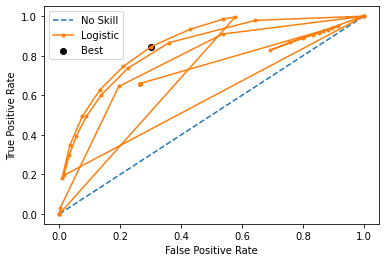

In [62]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(result_df['FPR'], result_df['TPR'], marker='.', label='Logistic')
pyplot.scatter(best_model['FPR'], best_model['TPR'], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

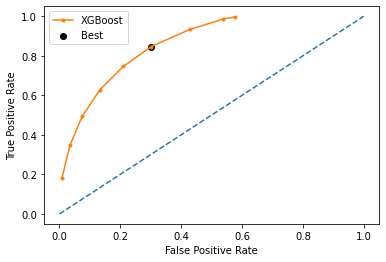

In [64]:
pyplot.plot([0,1], [0,1], linestyle='--')
pyplot.plot(xgb_df['FPR'], xgb_df['TPR'], marker='.', label='XGBoost')
pyplot.scatter(best_model['FPR'], best_model['TPR'], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
pyplot.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], xgb_df['tp'], "b--", label="tp")
pyplot.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], xgb_df['tn'], "g-", label="tn")
pyplot.legend()
pyplot.show()

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
def trainning_xgb():
    results = []
    iteration = 1
    
    params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

    # Cross-validation para TimeSeries
    for train_index, test_index in tscv.split(x):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        xgbr = xgb.XGBRegressor(seed = 20)
        clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
        clf.fit(x, y)
        print("Best parameters:", clf.best_params_)
        print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))    

In [ ]:
# trainning_xgb()

In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(x, y)
print("Best parameters:", clf.best_params_)